In [1]:
from utils import *
from dataset import *
from train import * 

In [2]:
torch_fix_seed(19981303)

In [3]:
def get_self_pretrain_model(index=1000):
    base_encoder = torchvision.models.resnet50(weights=None)
    base_encoder.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    origin_dim_mlp = base_encoder.fc.in_features
    base_encoder.fc = None
    temp = torch.load(f'./checkpoints/CEM_ALL_CHECK_{index}_Epoch.pth')['state_dict']
    state_dict = {}
    for k, v in temp.items():
        if 'encoder_q' in k:
            if 'fc' not in k:
                state_dict['.'.join(k.split('.')[1:])] = v
    base_encoder.load_state_dict(state_dict)
    base_encoder.fc = torch.nn.Linear(origin_dim_mlp, 512)
    return base_encoder

In [4]:
top_k_candidates = (20, 30, 40)
k = 7
temps = 0.7
momentums = 0.99
k_value = 64
# parameters = {'epochs_pretrain_model': list(range(100, 1100, 100))}
parameters = {'pretrain_model': ['self_pretrained', 'CEM', 'ImageNet', 'None']}
# parameters = {'pretrain_model': ['CEM']}
train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'], list(parameters.keys()))
parameters = list(itertools.product(*parameters.values()))

for i, parameter in enumerate(parameters):

    ### custom part to get parameters
    pretrain_model = parameter[0]
    ### END
    
    for j, images in enumerate(k_fold_train_validation_split(ORIGINAL_IMAGE, TARGET_IMAGE, k)):
        train_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, False)
        val_dataset = SingleChannelNDIDatasetContrastiveLearningWithAug(images, True)
        train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
        val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
        model = get_self_pretrain_model(index=pretrain_model)
        model = MoCo(model, dim=512, K=k_value, T=temps, m=momentums, mlp=True, customized_model=True)
        device = torch.device('cuda:0')
        criterion = nn.CrossEntropyLoss().cuda(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.015, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)
        start_time = time.time()
        print(f'Parameter Index: {i} / {len(parameters)}, Fold Index: {j} / {k}')
        metrics = train_moco_return_metrics_top_k(model, train_iter, val_iter, criterion, optimizer, 100, device,
                                                    tested_parameter=parameter, k_candidates=top_k_candidates, scheduler=scheduler)
        end_time = time.time()
        train_metrics.cal_add(metrics)
train_metrics.cal_divide(k)

Epoch 1, Train_Loss 3.929688286781311, Val_loss 4.187676906585693
Train_acc_top_20 0.1062	Train_acc_top_30 0.1625	Train_acc_top_40 0.2188	
Val_acc_top_20 0.12	Val_acc_top_30 0.17	Val_acc_top_40 0.21	
Epoch 2, Train_Loss 4.116767692565918, Val_loss 4.1739501953125
Train_acc_top_20 0.1375	Train_acc_top_30 0.1688	Train_acc_top_40 0.2188	
Val_acc_top_20 0.0	Val_acc_top_30 0.08	Val_acc_top_40 0.17	
Epoch 3, Train_Loss 4.062369060516358, Val_loss 4.148848056793213
Train_acc_top_20 0.1187	Train_acc_top_30 0.175	Train_acc_top_40 0.225	
Val_acc_top_20 0.0	Val_acc_top_30 0.04	Val_acc_top_40 0.08	
Epoch 4, Train_Loss 3.93734986782074, Val_loss 4.0801100730896
Train_acc_top_20 0.1187	Train_acc_top_30 0.15	Train_acc_top_40 0.2062	
Val_acc_top_20 0.0	Val_acc_top_30 0.0	Val_acc_top_40 0.04	
Epoch 5, Train_Loss 3.844912815093994, Val_loss 4.004388332366943
Train_acc_top_20 0.175	Train_acc_top_30 0.2437	Train_acc_top_40 0.2812	
Val_acc_top_20 0.08	Val_acc_top_30 0.17	Val_acc_top_40 0.25	
Epoch 6, Train

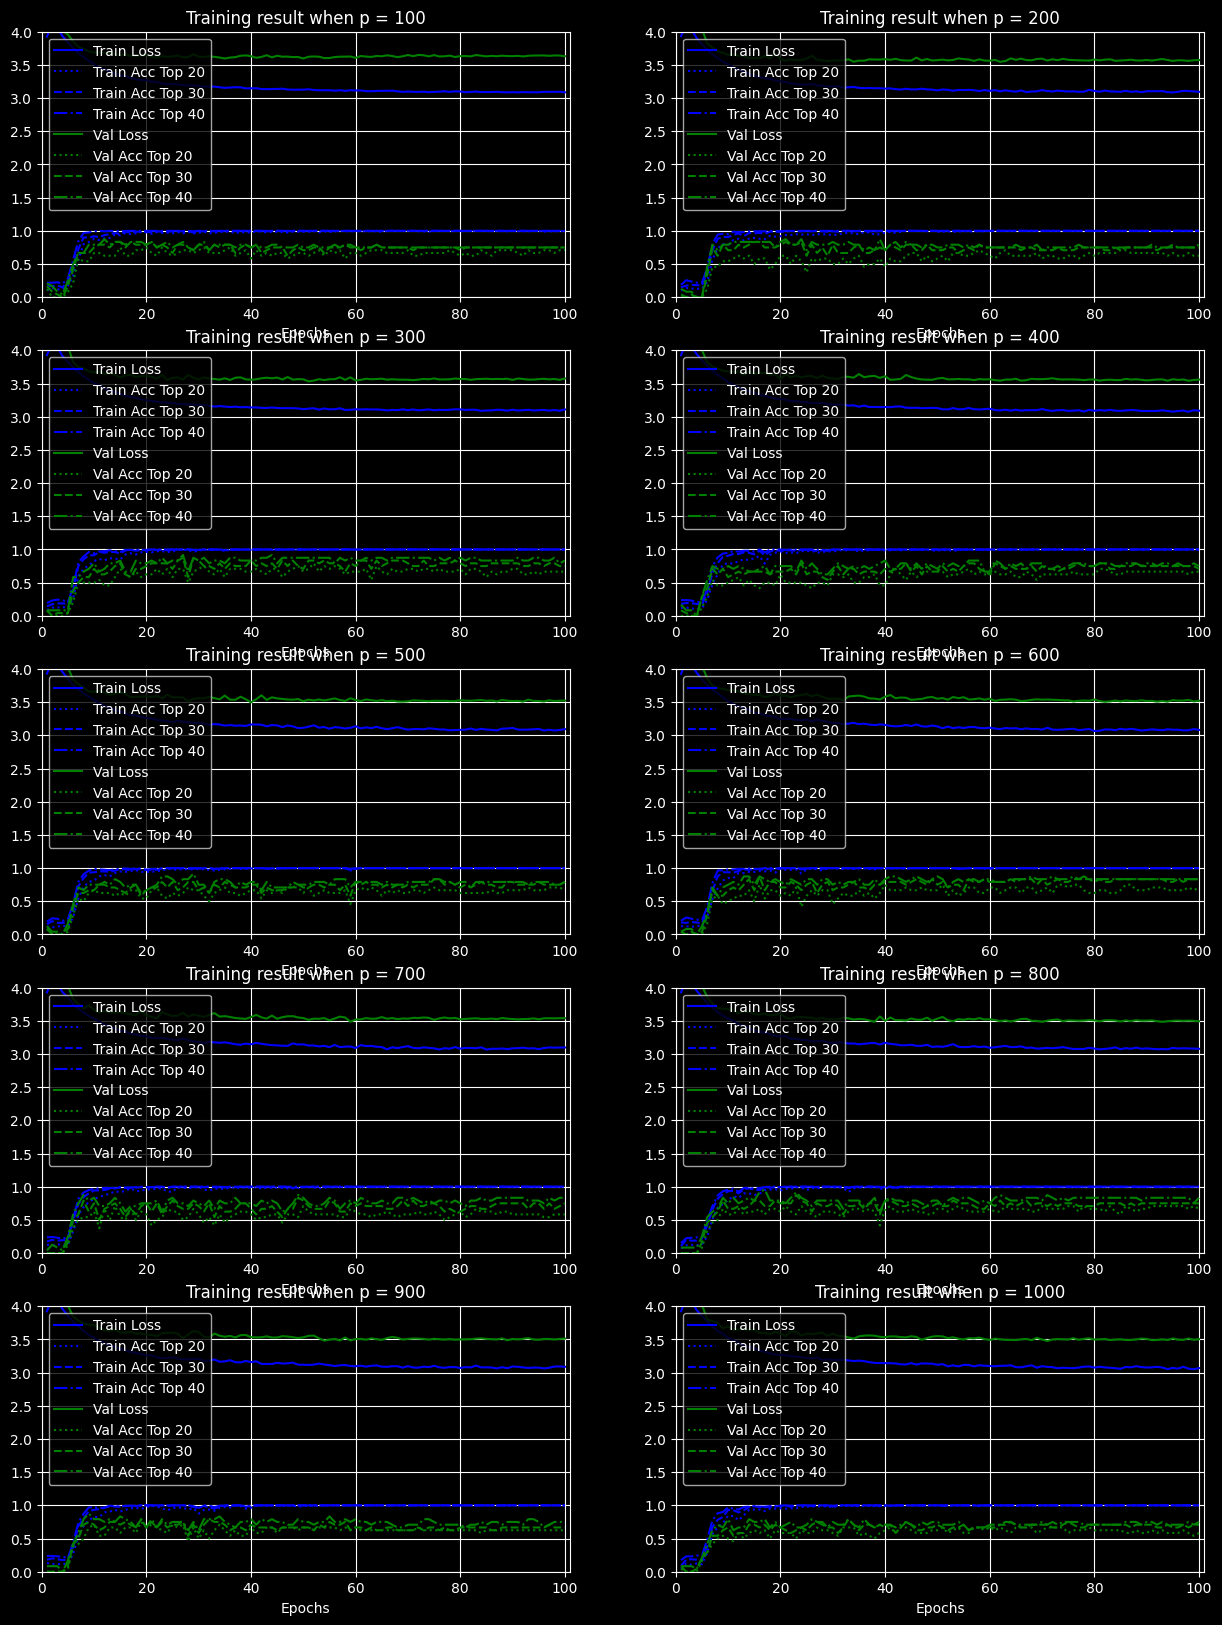

(100,) train loss mean 3.08605340208326
(100,) val loss mean 3.6336542878832137
(100,) 20 mean 0.6833333333333332
(100,) 20 max 0.75
(100,) 30 mean 0.75
(100,) 30 max 0.8333333333333334
(100,) 40 mean 0.75
(100,) 40 max 0.875
(200,) train loss mean 3.1032639946256366
(200,) val loss mean 3.5687300818307057
(200,) 20 mean 0.6458333333333333
(200,) 20 max 0.7083333333333334
(200,) 30 mean 0.7458333333333333
(200,) 30 max 0.8333333333333334
(200,) 40 mean 0.7625
(200,) 40 max 0.875
(300,) train loss mean 3.0943782431738716
(300,) val loss mean 3.5672928605760847
(300,) 20 mean 0.6583333333333334
(300,) 20 max 0.7916666666666666
(300,) 30 mean 0.7708333333333333
(300,) 30 max 0.875
(300,) 40 mean 0.8458333333333334
(300,) 40 max 0.9166666666666666
(400,) train loss mean 3.08684378692082
(400,) val loss mean 3.543745313371931
(400,) 20 mean 0.6625
(400,) 20 max 0.7083333333333334
(400,) 30 mean 0.7458333333333333
(400,) 30 max 0.7916666666666666
(400,) 40 mean 0.7708333333333333
(400,) 40 m

<Figure size 640x480 with 0 Axes>

In [5]:
draw_graph(train_metrics.data, 100, ('pretrain_epochs'))
for k, v in train_metrics.data.items():
    print(f'{k} train loss mean {np.mean(v[0][-10])}')
    print(f'{k} val loss mean {np.mean(v[2][-20])}')
    for k1 in v[1].keys():
        print(f'{k} {k1} mean {np.mean(v[3][k1][-10:])}')
        print(f'{k} {k1} max {np.max(v[3][k1])}')